# Run models

In Notebook 3 we learn how to train and predict built-in ECG models. We consider [fft_inceprion](https://github.com/analysiscenter/cardio/blob/master/doc/fft_model.md) model as an example. This model learns to recognize atrial fibrillation (AF) from single lead ECG signal. Input of the model is ECG signal and meta, output is probability of signal being AF and non-AF. See more on ecg models [here](https://github.com/analysiscenter/cardio/blob/master/doc/models.md).

Some necessary imports before to start. We import ```dataset``` that will generate batches, ```EcgBatch``` that will store ECG and ```FFTModel``` that contains model we will train.

In [1]:
import numpy as np
from sklearn.metrics import f1_score
import sys
import os
sys.path.append(os.path.join(".."))

import tensorflow as tf
%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

import cardio.dataset as ds
from cardio import EcgBatch

from cardio.dataset import F, V
from cardio.models.fft_model import FFTModel

env: CUDA_VISIBLE_DEVICES=0


Using TensorFlow backend.


Next we create an ECG dataset (see [Notebook 1](https://github.com/analysiscenter/cardio/blob/master/doc/ecg_tutorial_part_1.ipynb) for details):

In [2]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=EcgBatch)

Usually we want to divide the whole dataset into 2 parts that will be used for train and validation. Method ```cv_split``` do this job:

In [3]:
eds.cv_split(0.8, shuffle=True)

Now 80% of the dataset are in ```eds.train``` and the rest are in ```eds.test```.

## Train pipeline

Let's define a train pipeline. Pipeline is a declaration of actions that we want do, namely
* initialize model, adjust it to the input signal shape, specify loss and optimizer
* initialize variable that will store loss history
* load signal, meta and target labels
* drop noise signals
* replace all non-AF labels with "NO" label
* resample signal
* drop too short signals
* generate a number of segments from each signal
* binarize labels to 0 and 1
* prepare signal to expected model input format
* train model.

In [4]:
model_config = {
    "input_shape": F(lambda batch: batch.signal[0].shape),
    "loss": "binary_crossentropy",
    "optimizer": "adam"
}

def make_data(batch, **kwagrs):
    return {'x': np.array(list(batch.signal)), 'y': batch.target}

train_pipeline = (ds.Pipeline()
                  .init_model("dynamic", FFTModel, name="fft_model", config=model_config)
                  .init_variable("loss_history", init=list)
                  .load(fmt="wfdb", components=["signal", "meta"])
                  .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                        fmt="csv", components="target")
                  .drop_labels(["~"])
                  .replace_labels({"N": "NO", "O": "NO"})
                  .random_resample_signals("normal", loc=300, scale=10)
                  .drop_short_signals(4000)
                  .split_signals(3000, 3000)
                  .binarize_labels()
                  .apply(np.transpose , axes=[0, 2, 1])
                  .ravel()
                  .train_model('fft_model', make_data=make_data,
                               save_to=V("loss_history"), mode="a"))

Then we only have to pass the dataset to pipeline and run the calculation. Depending on your hardware training may take a while. Reduce ```n_epochs``` if you do not want to wait long:

In [26]:
fft_trained = (eds.train >> train_pipeline).run(batch_size=300, shuffle=True,
                                                drop_last=True, n_epochs=10)

As a result we obtain ```fft_trained``` that contains trained model. Let's make a prediction!

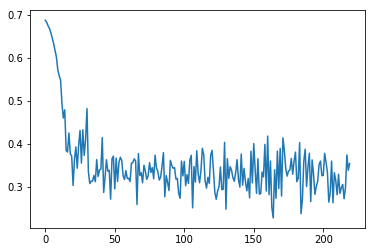

In [27]:
import matplotlib.pyplot as plt
plt.plot(fft_trained.get_variable("loss_history"))
plt.show()

## Test pipeline

Test pipeline is very similar to train pipeline except several things. First, rather than initialize a new model we import pretrained model from train_pipeline. Alternative option woulb be importing model from model dump. Second, we add new vairable ```true_targets``` than will keep targets from batch. Finally, we call model predict rather than model train.

In [6]:
test_pipeline = (ds.Pipeline()
                 .import_model("fft_model", train_pipeline)
                 .init_variable("pred_targets", init=list)
                 .init_variable("true_targets", init=list)
                 .load(fmt="wfdb", components=["signal", "meta"])
                 .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                       fmt="csv", components="target")
                 .drop_labels(["~"])
                 .replace_labels({"N": "NO", "O": "NO"})
                 .random_resample_signals("normal", loc=300, scale=10)
                 .drop_short_signals(4000)
                 .split_signals(3000, 3000)
                 .binarize_labels()
                 .apply(np.transpose , axes=[0, 2, 1])
                 .ravel()
                 .get_targets('true_targets', mode="e")
                 .predict_model('fft_model', make_data=make_data,
                                save_to=V("pred_targets"), mode="e", metrics=f1_score))

Let's run prediction pipeline. Note we set ```n_epochs=1```:

In [8]:
res_test = (eds.test >> test_pipeline).run(batch_size=300, shuffle=False, drop_last=False,
                                           n_epochs=1, prefetch=0)

Now we can access true labels as ```res_test.get_variable("true_targets")``` and predicted class probabilities
as ```res_test.get_variable("pred_targets")```. Consider several predicted values:

In [10]:
res_test.get_variable("pred_targets")[:10]

[array([ 0.50236195,  0.49763802], dtype=float32),
 array([ 0.50094545,  0.49905455], dtype=float32),
 array([ 0.50120556,  0.49879444], dtype=float32),
 array([ 0.50081229,  0.49918774], dtype=float32),
 array([ 0.50088251,  0.49911755], dtype=float32),
 array([ 0.50170994,  0.49829012], dtype=float32),
 array([ 0.50167441,  0.49832562], dtype=float32),
 array([ 0.50448787,  0.49551219], dtype=float32),
 array([ 0.50244385,  0.49755615], dtype=float32),
 array([ 0.50251603,  0.497484  ], dtype=float32)]

Here each column corresponds to class probality (AF or non-AF). To get class prediction we simply take most probable class. Metrics f1_score allows to estimate model quality: 

In [22]:
f1_score(np.array(res_test.get_variable("true_targets"))[:, 0],
         np.rint(res_test.get_variable("pred_targets"))[:, 0], average='macro')

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.07627289192996578

This is the end of Notebook 3. Here we learned:
* how to train models
* how to test model quality.

See previous topics in [Notebook 1](https://github.com/analysiscenter/cardio/blob/master/doc/ecg_tutorial_part_1.ipynb) and [Notebook 2](https://github.com/analysiscenter/cardio/blob/master/doc/ecg_tutorial_part_2.ipynb).